# Lab assignment №1, part 2

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the second part of the assignment. First and third parts are waiting for you in the same directory.*__

## Part 2. Data preprocessing, model training and evaluation.

### 1. Reading the data
Today we work with the [dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29), describing different cars for multiclass ($k=4$) classification problem. The data is available below.

In [60]:
# If on colab, uncomment the following lines

# ! wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_made/homeworks/lab01_ml_pipeline/car_data.csv

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.base import BaseEstimator, TransformerMixin
from collections import deque
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from scikitplot.metrics import plot_roc

import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
dataset = pd.read_csv('car_data.csv', delimiter=',', header=None)
dataset.drop(labels=0, axis=1, inplace=True)
dataset = dataset.values

data = dataset[:, :-1].astype(int)
target = dataset[:, -1]

print(data.shape, target.shape)

(846, 18) (846,)


In [63]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.35, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(549, 18) (549,) (297, 18) (297,)


To get some insights about the dataset, `pandas` might be used. The `train` part is transformed to `pd.DataFrame` below.

In [64]:
X_train_pd = pd.DataFrame(X_train)

# First 15 rows of our dataset.
X_train_pd.head(15)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,95,41,82,170,65,9,145,46,19,145,163,314,140,64,4,8,199,207
1,104,57,103,222,72,12,221,30,25,177,223,718,218,72,11,12,186,195
2,91,42,66,169,66,7,145,44,19,140,169,325,159,67,4,0,201,207
3,109,52,95,189,58,4,227,29,25,158,262,776,217,82,0,19,187,186
4,95,47,73,195,70,7,167,38,20,152,184,430,185,69,9,19,200,206
5,81,44,72,139,60,6,153,44,19,146,180,347,178,81,1,15,182,186
6,93,34,66,140,56,7,130,51,18,120,151,251,114,62,5,29,201,207
7,89,43,77,147,54,8,144,46,19,146,163,308,174,64,13,5,194,201
8,117,52,110,228,65,12,212,31,24,163,228,668,220,66,21,25,194,205
9,109,49,109,193,59,10,207,32,24,156,225,635,213,70,13,31,191,202


Methods `describe` and `info` deliver some useful information.

In [65]:
X_train_pd.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,549.0,93.520947,8.063277,76.0,87.0,93.0,99.0,117.0
1,549.0,44.675774,6.154680,33.0,40.0,44.0,49.0,59.0
2,549.0,81.801457,15.928751,42.0,70.0,79.0,98.0,110.0
3,549.0,168.204007,33.047995,104.0,140.0,165.0,195.0,306.0
4,549.0,61.644809,7.110666,47.0,57.0,61.0,66.0,126.0
5,549.0,8.457195,3.945857,2.0,7.0,8.0,10.0,52.0
6,549.0,167.327869,32.506680,114.0,146.0,157.0,196.0,265.0
7,549.0,41.273224,7.777590,26.0,34.0,43.0,46.0,59.0
8,549.0,20.468124,2.526030,17.0,19.0,20.0,23.0,29.0
9,549.0,147.438980,14.631309,118.0,136.0,145.0,159.0,186.0


In [66]:
X_train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       549 non-null    int32
 1   1       549 non-null    int32
 2   2       549 non-null    int32
 3   3       549 non-null    int32
 4   4       549 non-null    int32
 5   5       549 non-null    int32
 6   6       549 non-null    int32
 7   7       549 non-null    int32
 8   8       549 non-null    int32
 9   9       549 non-null    int32
 10  10      549 non-null    int32
 11  11      549 non-null    int32
 12  12      549 non-null    int32
 13  13      549 non-null    int32
 14  14      549 non-null    int32
 15  15      549 non-null    int32
 16  16      549 non-null    int32
 17  17      549 non-null    int32
dtypes: int32(18)
memory usage: 38.7 KB


### 2. Machine Learning pipeline
Here you are supposed to perform the desired transformations. Please, explain your results briefly after each task.

#### 2.0. Data preprocessing
* Make some transformations of the dataset (if necessary). Briefly explain the transformations

In [67]:
sns.set_color_codes()   # style="whitegrid"
sns.set_theme()
%matplotlib inline

In [68]:
def boxplot(figRows, figCols, xSize, ySize, features, colors, hue=None, orient='h', df=X_train_pd):
    f, axes = plt.subplots(figRows, figCols, figsize=(xSize, ySize))
    
    features = np.array(features).reshape(figRows, figCols)
    colors = np.array(colors).reshape(-1, figCols)
    
    for row in range(figRows):
        for col in range(figCols):
            if (figRows == 1 and figCols == 1) :
                axesplt = axes
            elif (figRows == 1 and figCols > 1) :
                axesplt = axes[col]
            elif (figRows > 1 and figCols == 1) :
                axesplt = axes[row]
            else:
                axesplt = axes[row][col]
            plot = sns.boxplot(data=df, x=features[row][col], color=colors[row][col], ax=axesplt, orient=orient, hue=hue)
            plot.set_ylabel('',fontsize=14)
            # plot.set_xticks([features[row][col]])
            # plot.set_xticklabels(rotation=rotation, labels=[features[row][col]], fontweight='bold',fontsize='medium')


def boxplot_all(xSize, ySize, palette, data):
    f, axes = plt.subplots(1, 1, figsize=(xSize, ySize))
    plot = sns.boxplot(x='variable',y='value', data= pd.melt(data), palette=palette, ax=axes, orient='v')
    plot.set_xlabel('',fontsize=20)
    plot.set_xticklabels(rotation=60, labels=plot.get_xticklabels(),fontweight='bold',fontsize='medium')  

pal = sns.color_palette(palette='Set1', n_colors=16)


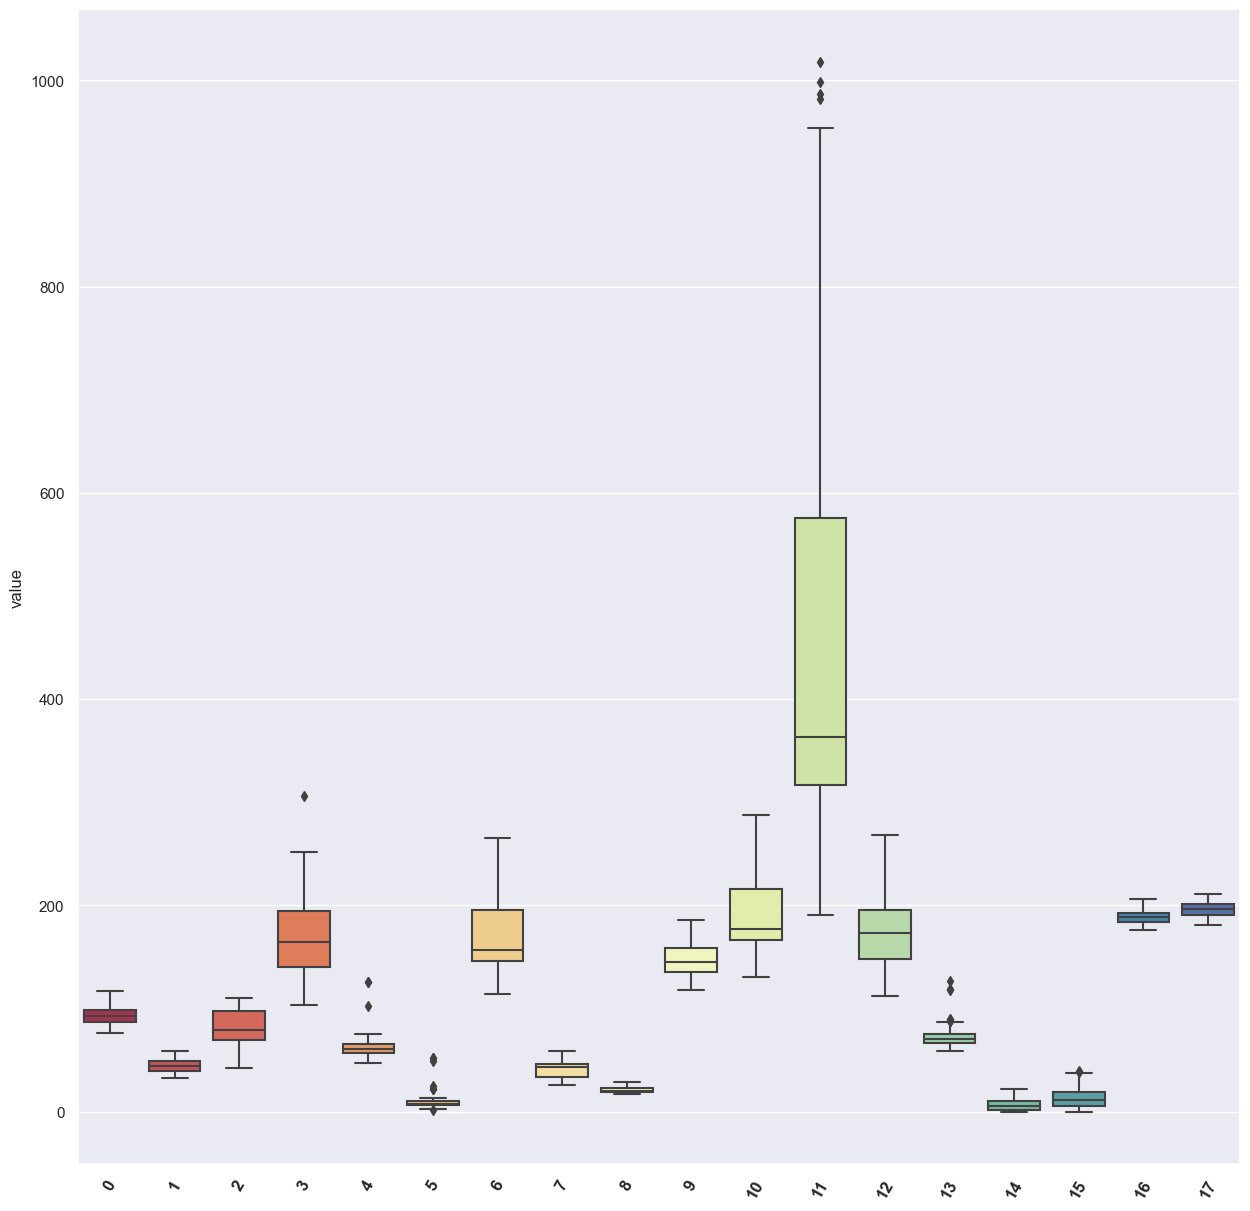

In [69]:
boxplot_all(15,15,palette="Spectral", data=X_train_pd)

Выбросы обнаружены для следующих признаков: 3, 4, 5, 11, 13, 15

In [70]:
#Measure of Skewness
X_train_pd.skew().sort_values()

17   -0.277685
7     0.052380
2     0.135022
16    0.212061
3     0.233597
9     0.255671
12    0.272900
1     0.285335
0     0.428710
10    0.588521
6     0.634192
15    0.650705
14    0.729000
8     0.805178
11    0.867475
13    2.027348
4     3.046796
5     7.125484
dtype: float64

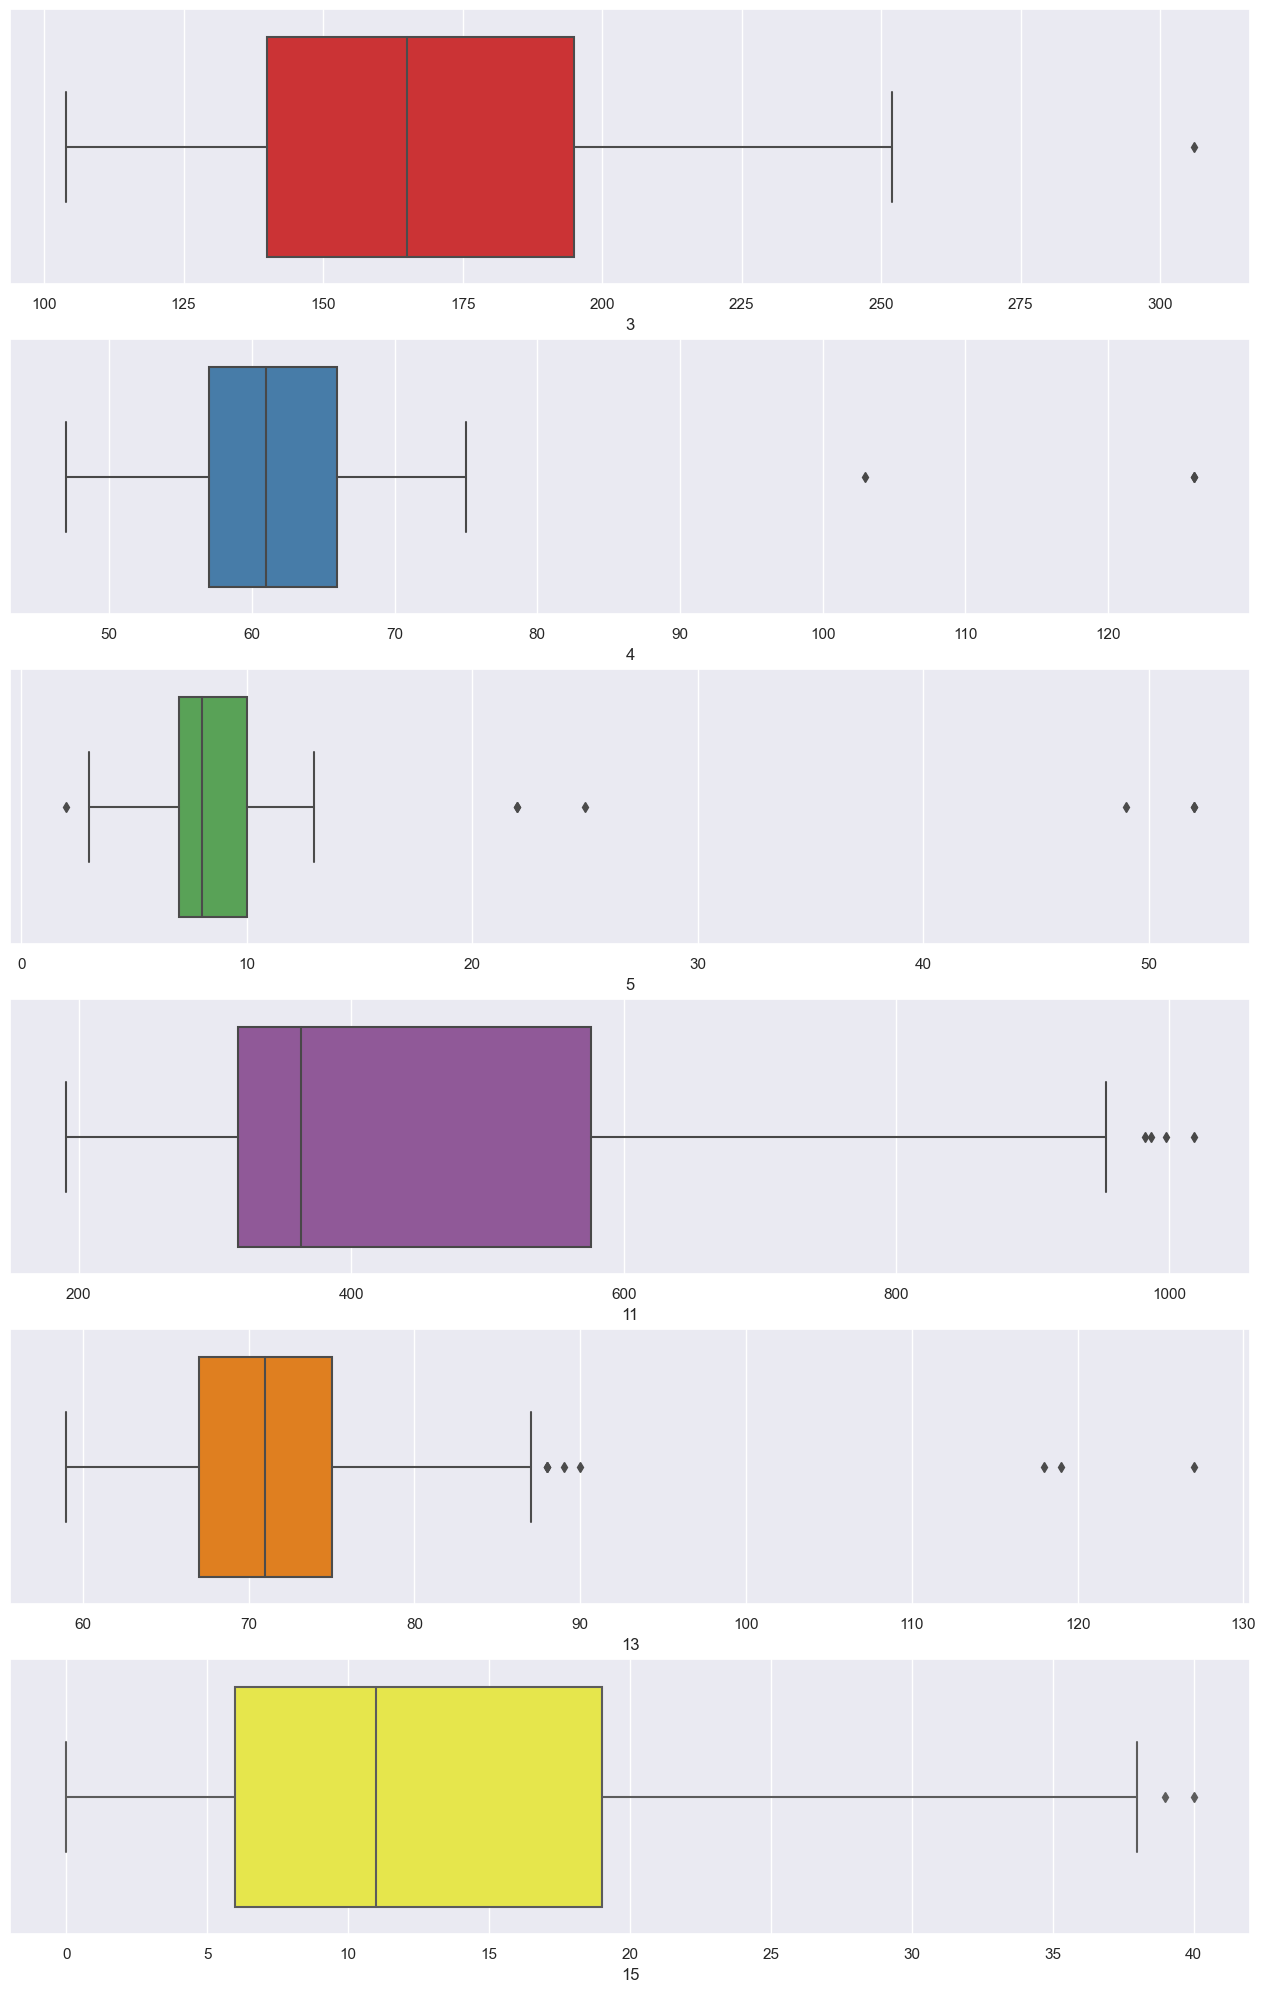

In [71]:
boxplot(6, 1, 16, 25, features=[3, 4, 5, 11, 13, 15], colors=pal.as_hex()[:6])

Все 6 признаков имеют выбросы в области больших значений

In [72]:
def remove_outliers(col, data):
    outlier_col = str(col) + "_outliers"
    data[outlier_col] = data[col]
    data[outlier_col]= zscore(data[outlier_col])

    condition = (data[outlier_col]>3) | (data[outlier_col]<-3)
    indices.extend(data[condition].index.tolist())

    data.drop(data[condition].index, axis = 0, inplace = True)
    data.drop(outlier_col, axis=1, inplace=True)

In [73]:
indices = []
to_clean = [3, 4, 5, 11, 13, 15]

func = partial(remove_outliers, data=X_train_pd)
deque(map(func, to_clean))

print(indices, f"В результате было удалено {len(indices)} объектов", sep="\n")

[255, 150, 411, 160, 218, 433, 33, 123, 170, 172, 387, 42]
В результате было удалено 12 объектов


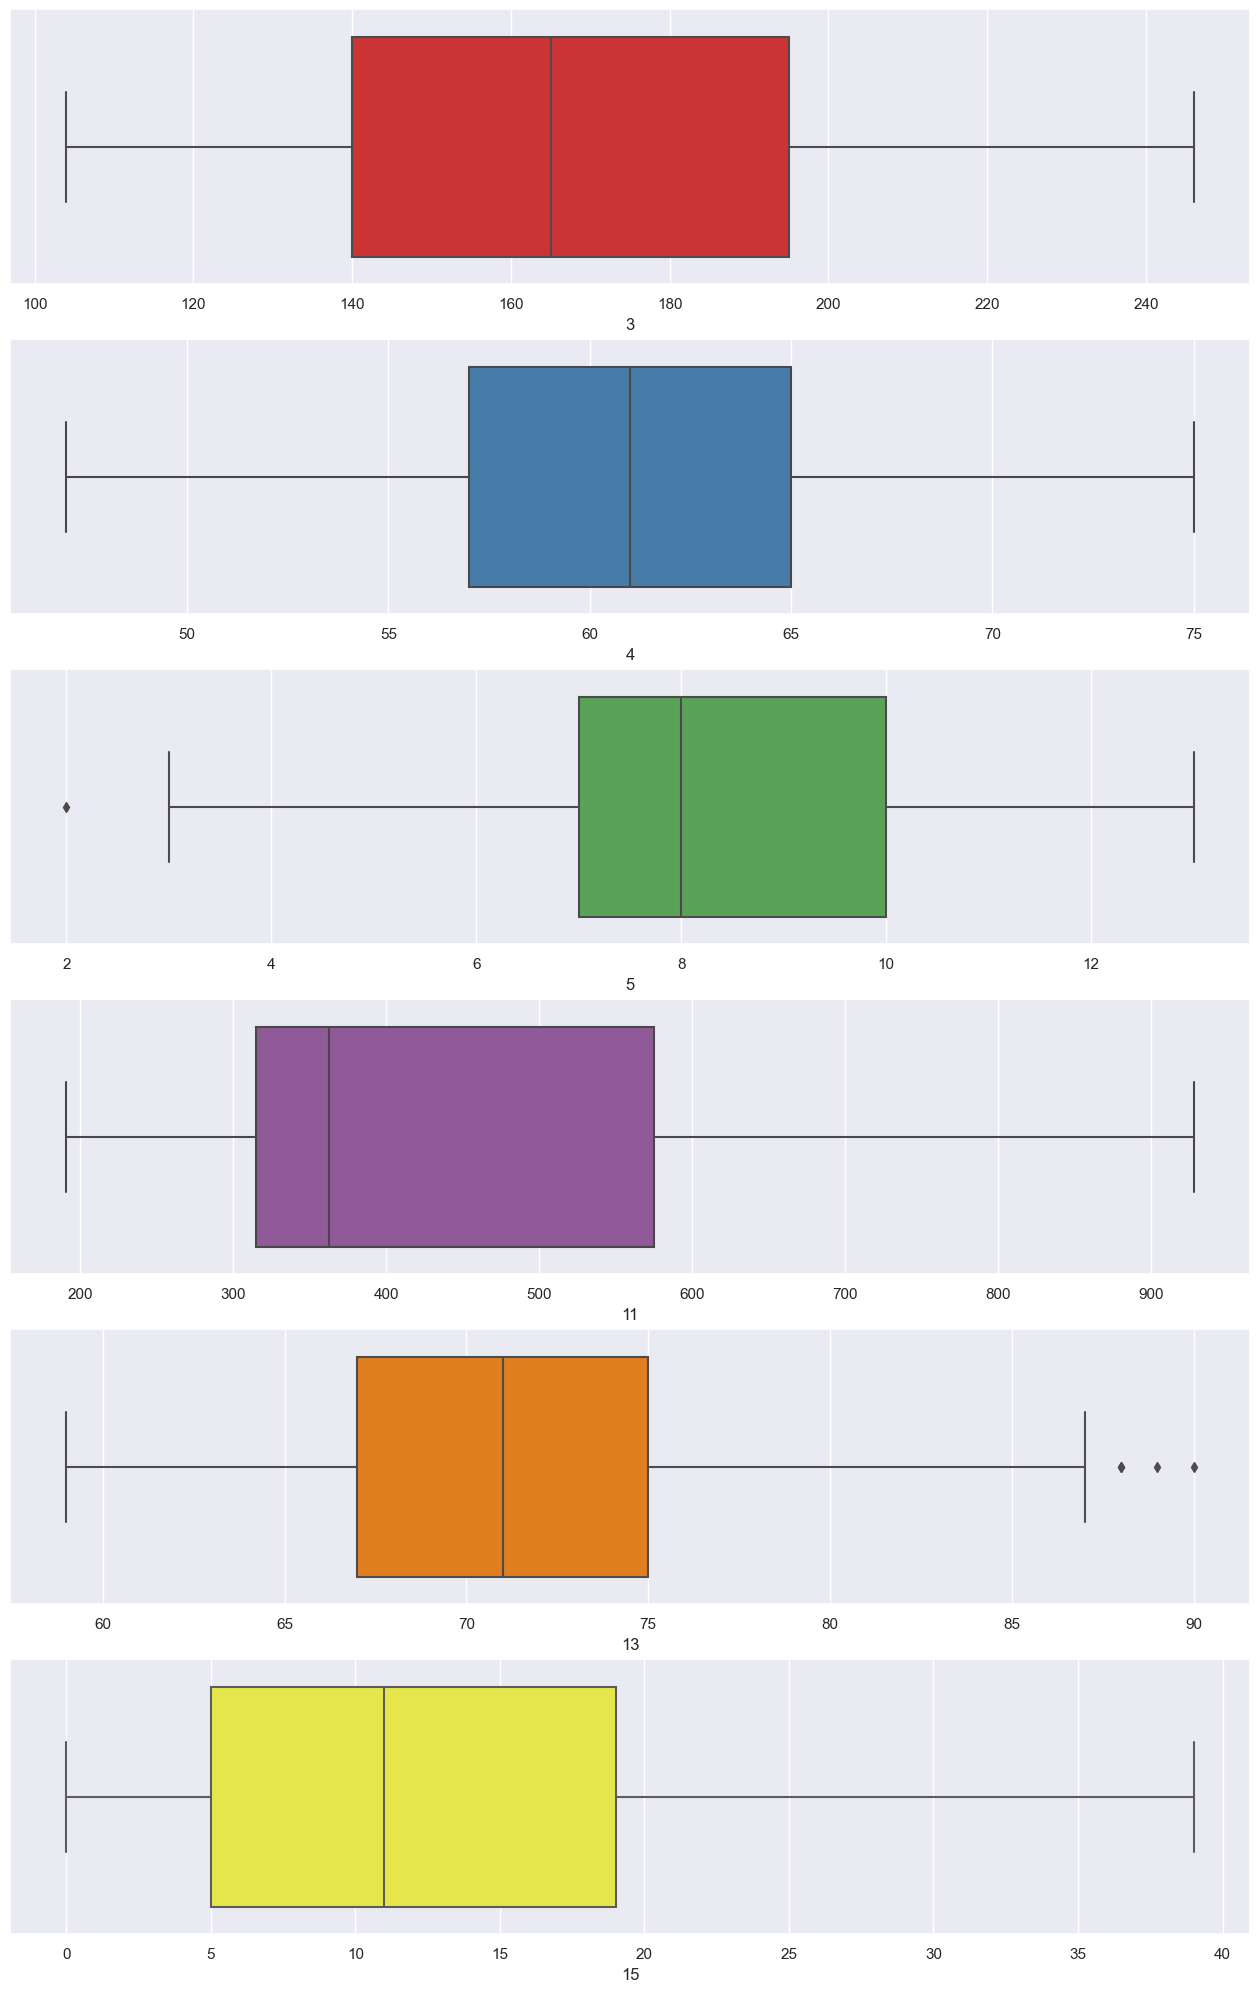

In [74]:
boxplot(6, 1, 16, 25, features=[3, 4, 5, 11, 13, 15], colors=pal.as_hex()[:6])

In [75]:
X_train_pd.skew().sort_values()

17   -0.299707
5    -0.000853
7     0.088661
3     0.117987
4     0.124377
2     0.127852
16    0.194833
12    0.210749
9     0.255265
1     0.267867
10    0.414111
0     0.418481
6     0.528989
15    0.633657
13    0.652674
8     0.686148
11    0.716815
14    0.725179
dtype: float64

In [76]:
X_train_new = X_train_pd.copy().values

Удаление атрибутов мультиколлинеарных атрибутов

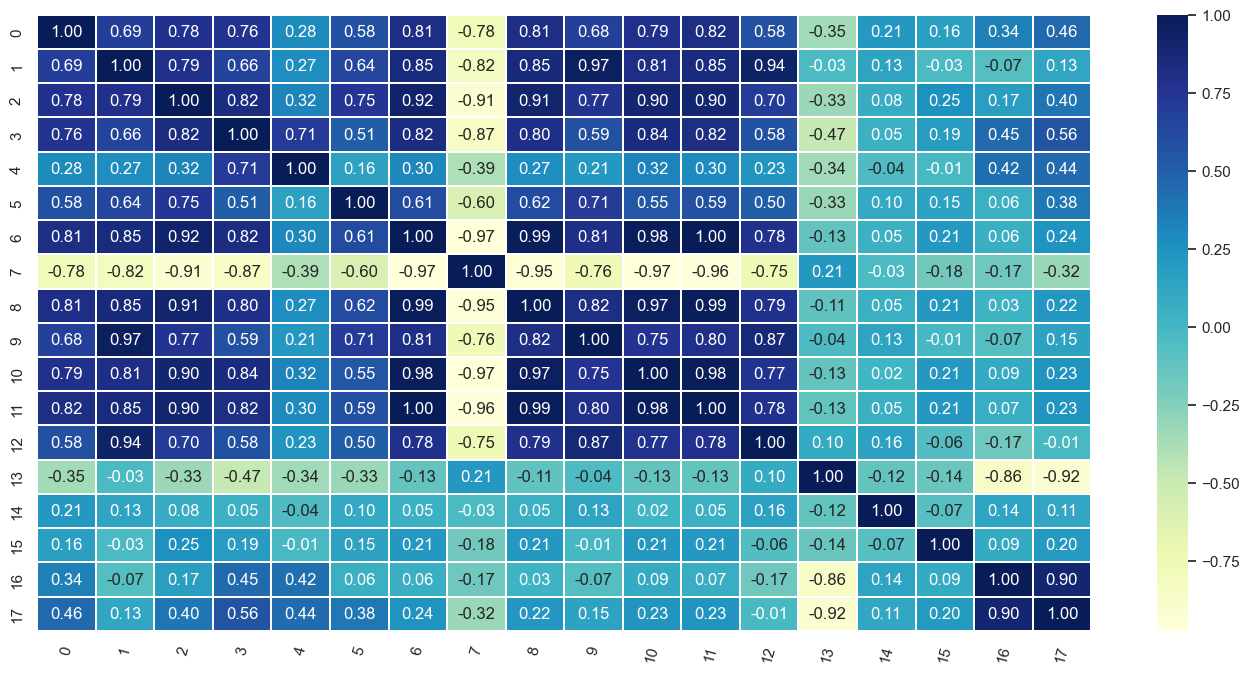

In [77]:
f, axes = plt.subplots(1, 1, figsize=(17, 8))
cor_mat = X_train_pd.corr()
hplot = sns.heatmap(cor_mat, annot=True, fmt=".2f", ax=axes, linecolor='white', linewidths=0.2, cmap='YlGnBu')
plt.xticks(rotation=75);

Из тепловой карты можно заметить, что есть несколько атрибутов, которые сильно коррелируют друг с другом как с отрицательным коэффициентом так и с положительным

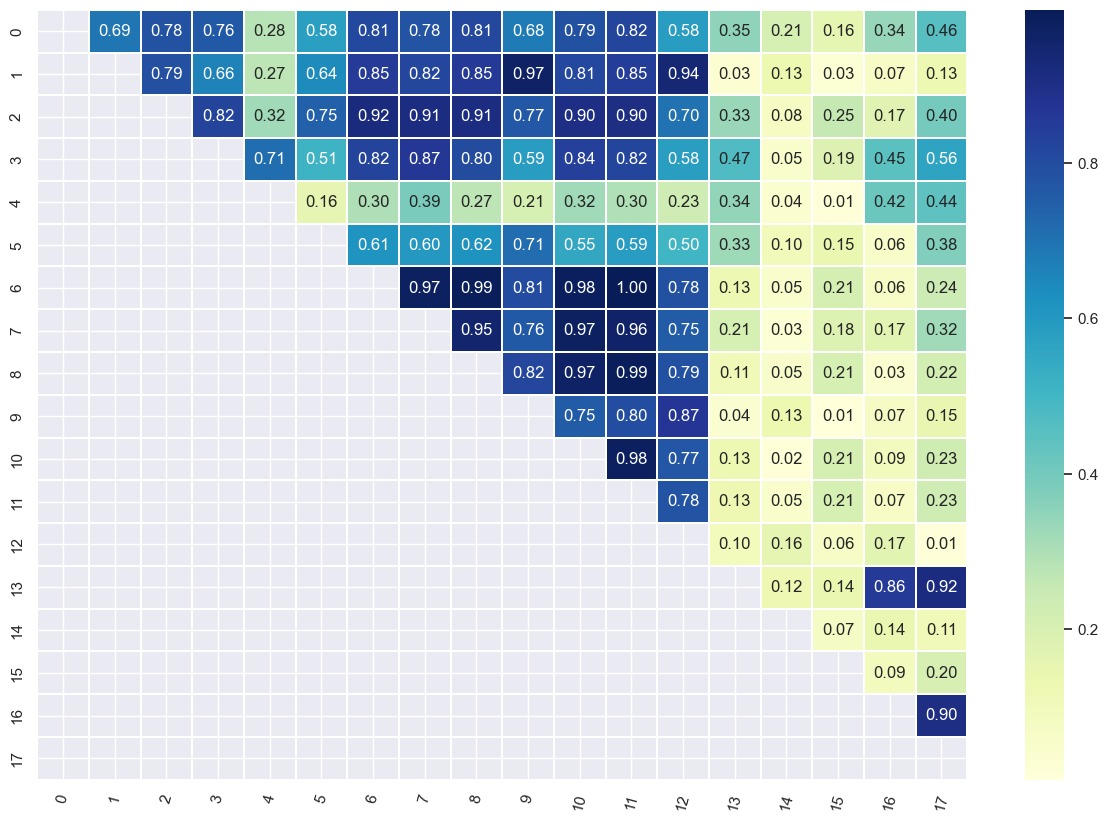

In [78]:
def CorrelationUpper(data):
    # Create correlation matrix
    corr_matrix = data.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    _, axes = plt.subplots(1, 1, figsize=(15, 10))
    sns.heatmap(upper,cmap='YlGnBu', annot=True, fmt=".2f", ax=axes, linecolor='white', linewidths=0.2)
    plt.xticks(rotation=75)
    return upper

upper = CorrelationUpper(X_train_pd)

In [79]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(f"List of columns with correlation higher than 0.90: {*to_drop, }")

List of columns with correlation higher than 0.90: (6, 7, 8, 9, 10, 11, 12, 17)


In [80]:
#X_train_pd.drop(to_drop, axis=1, inplace=True)

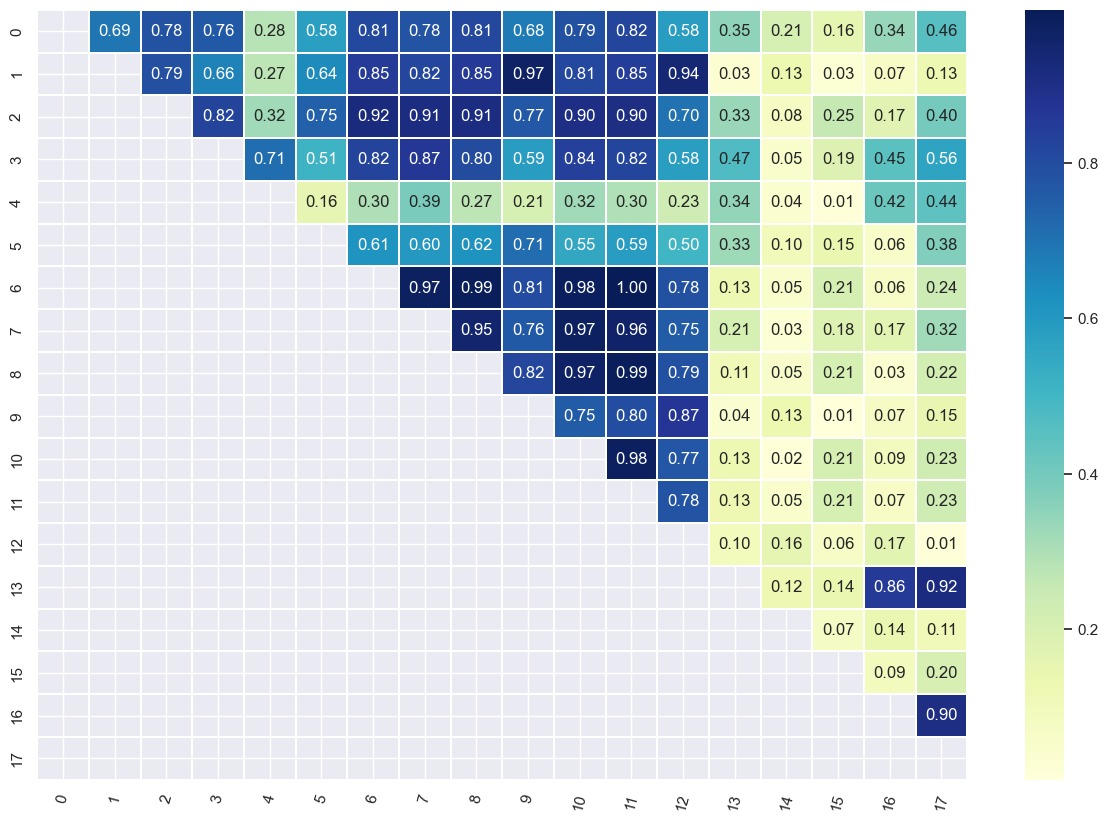

In [81]:
upper = CorrelationUpper(X_train_pd)

In [82]:
X_train_pd.shape

(537, 18)

In [83]:
X_train_pd.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,537.0,93.458101,7.950090,76.0,87.0,93.0,99.0,117.0
1,537.0,44.584730,6.080062,33.0,40.0,44.0,49.0,59.0
2,537.0,81.711359,15.861472,42.0,70.0,79.0,98.0,110.0
3,537.0,167.541899,32.462875,104.0,140.0,165.0,195.0,246.0
4,537.0,61.361266,5.662444,47.0,57.0,61.0,65.0,75.0
5,537.0,8.156425,2.108467,2.0,7.0,8.0,10.0,13.0
6,537.0,166.687151,31.521298,114.0,145.0,157.0,195.0,252.0
7,537.0,41.368715,7.712051,27.0,34.0,43.0,46.0,59.0
8,537.0,20.415270,2.435126,17.0,19.0,20.0,22.0,28.0
9,537.0,147.258845,14.564385,118.0,136.0,145.0,158.0,186.0


In [84]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, corr_coef=0.9):
        self.corr_coef = corr_coef
        self.to_drop_ = None    
        
    def fit(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        corr_matrix = X.corr().abs()
        # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop_ = [column for column in upper.columns if any(upper[column] > self.corr_coef)]
        return self

    def transform(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        X.drop(self.to_drop_, axis=1, inplace=True)
        
        return X.values


In [85]:
Y_train_pd = pd.Series(y_train)
y_train_new = Y_train_pd.drop(index=indices).values

features_preprocessor = Pipeline(
    steps=[
        ("cleaner", CustomTransformer()),
        ("scaler", StandardScaler()),
    ]
)
features_preprocessor.fit(X_train_new)
X_train_tr = features_preprocessor.transform(X_train_new)

Label_encoder = LabelEncoder()
y_train_tr = Label_encoder.fit_transform(y_train_new)

X_train_tr.shape, y_train_tr.shape

((537, 10), (537,))

In [122]:
X_train_tr

array([[  3.63617499,  -8.76687597,   0.44705419,  -8.87156755,
         -5.61108858,  -1.84777874],
       [ 60.60868723,   1.90930396,  -7.85702634,   6.28048544,
          5.50414746,   3.19051485],
       [ -4.4095601 , -22.22976702,  -6.57626157,  -4.66712275,
         -2.02938843,  -3.51793122],
       ...,
       [-23.96684877,  -6.80651533, -13.86397403,  11.33719825,
         -1.53923416,   5.08115451],
       [-26.74189018,  -9.51170986,   7.79506143,  -4.62321606,
         -6.06103017,   0.26306409],
       [-20.63105189,  -8.97647531,  -4.57657904,  -7.25607443,
          6.461588  ,   1.47087929]])

#### 2.1. Basic logistic regression
* Find optimal hyperparameters for logistic regression with cross-validation on the `train` data (small grid/random search is enough, no need to find the *best* parameters).

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` `tol=1e-3` and ` max_iter=500`.*

In [86]:
C = np.logspace(0, 4, num=10)
penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

clf = LogisticRegression(
    multi_class="multinomial",
    solver="saga", 
    tol=1e-3, 
    max_iter=500
)
randomizedsearch = RandomizedSearchCV(clf, hyperparameters, cv=7, random_state=42)
best_model_random = randomizedsearch.fit(X_train_tr, y_train_tr)
print(best_model_random.best_estimator_)

LogisticRegression(C=7.742636826811269, max_iter=500, multi_class='multinomial',
                   solver='saga', tol=0.001)


In [87]:
y_test_tr = Label_encoder.transform(y_test)
X_test_tr = features_preprocessor.transform(X_test)

y_predict = best_model_random.best_estimator_.predict(X_test_tr)
y_probs = best_model_random.best_estimator_.predict_proba(X_test_tr)

print(
    f"f1 score = {round(f1_score(y_test_tr, y_predict, average='weighted'), 4)}",
    f"accuracy score = {round(accuracy_score(y_test_tr, y_predict), 4)}",
    sep="\n"
)


f1 score = 0.7557
accuracy score = 0.7576


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

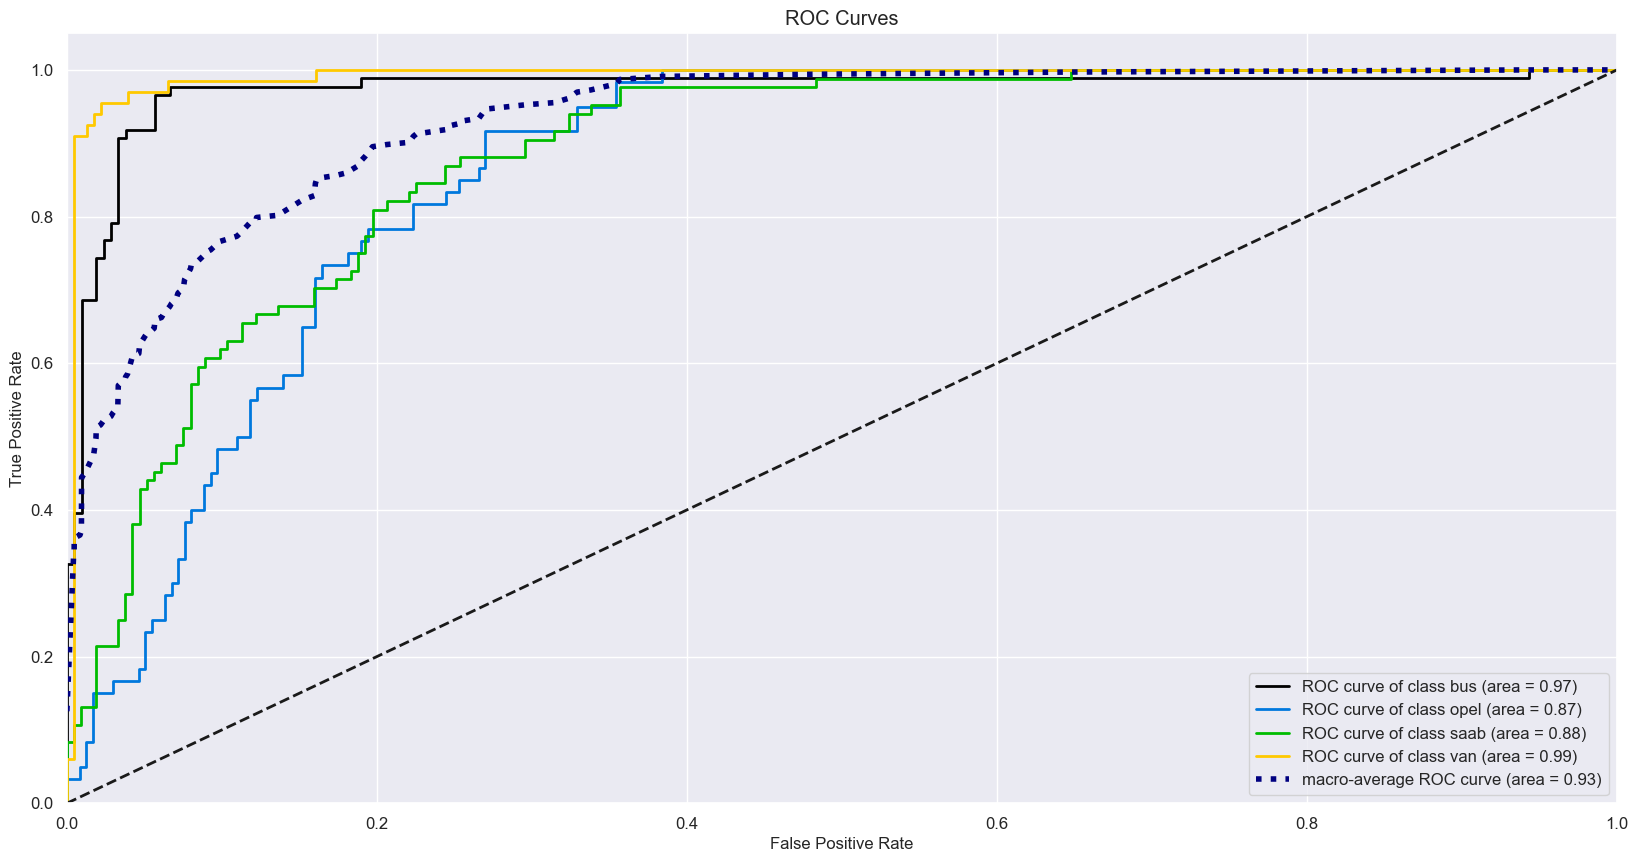

In [88]:
plot_roc(y_test, y_probs, figsize=(20, 10), plot_micro=False)

#### 2.2. PCA: explained variance plot
* Apply the PCA to the train part of the data. Build the explaided variance plot. 

In [89]:
from sklearn.decomposition import PCA

In [90]:
cleaner = CustomTransformer()
X_train_pca =cleaner.fit_transform(X_train_new)

In [91]:
n_comp = X_train_pca.shape[1]
pca = PCA(n_components=n_comp)
pca.fit(X_train_pca)

PCA(n_components=10)

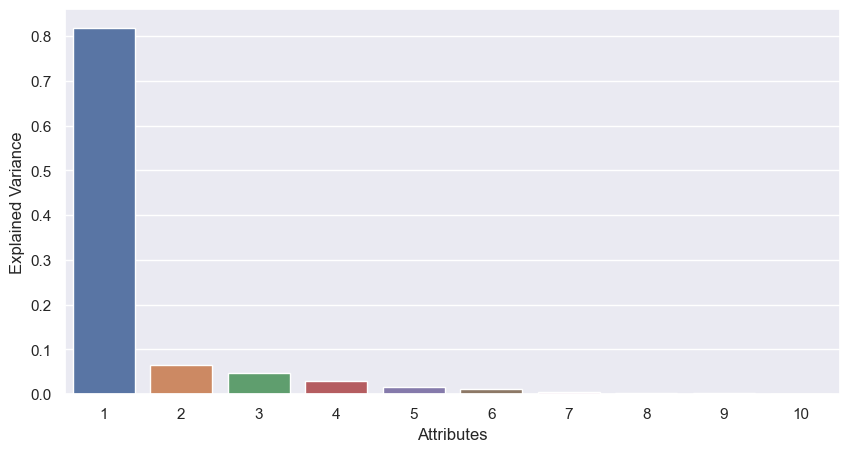

In [92]:
boundary = len(pca.explained_variance_ratio_) + 1
_, axes = plt.subplots(1, 1, figsize=(10, 5))
plot = sns.barplot(x=list(range(1, boundary)), y=pca.explained_variance_ratio_, ax=axes)
# plot = sns.pointplot(x=list(range(1,11)), y=pca.explained_variance_ratio_, ax=axes, color='darkgreen')
plot.set_xlabel('Attributes')
plot.set_ylabel('Explained Variance');

In [93]:
sum(pca.explained_variance_ratio_[:6])

0.9884183425681708

#### 2.3. PCA trasformation
* Select the appropriate number of components. Briefly explain your choice. Should you normalize the data?

*Use `fit` and `transform` methods to transform the `train` and `test` parts.*

Эффективная размерность выборки —  4  (при этом будут учтены 96 процентов информации) Используем данное значение в качестве значения количества компонент

In [94]:
n = 6
pca = PCA(n_components=n)
X_train_tr = pca.fit_transform(X_train_pca)
X_train_tr_pd = pd.DataFrame(X_train_tr)
X_train_tr_pd.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,537.0,4.340000e-15,36.449047,-73.008143,-29.388331,-2.377454,31.219526,81.378806
1,537.0,4.763415e-16,10.280570,-25.565885,-7.313589,0.583524,6.775851,33.913133
2,537.0,-4.803110e-15,8.797320,-16.903438,-6.773792,-0.864355,5.378846,28.548499
3,537.0,1.048282e-14,7.020232,-19.219804,-4.807524,0.044978,5.149452,19.862160
4,537.0,8.018415e-15,5.048041,-10.373463,-3.787562,-0.490308,3.267209,16.321555
5,537.0,-5.054513e-15,4.193550,-13.565697,-2.665658,0.084492,2.722919,15.181022


**Note: From this point `sklearn` [Pipeline](https://scikit-learn.org/stable/modules/compose.html) might be useful to perform transformations on the data. Refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for more information.**

#### 2.4. Logistic regression on PCA-preprocessed data.
* Find optimal hyperparameters for logistic regression with cross-validation on the transformed by PCA `train` data.

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` and `tol=1e-3`*

In [95]:
# Label_encoder = LabelEncoder()
# y_train_tr = Label_encoder.fit_transform(y_train_new)
X_train_tr.shape, y_train_tr.shape

((537, 6), (537,))

In [96]:
# features_scaler = StandardScaler()
# X_train_pca_ = features_scaler.fit_transform(X_train_tr)

C = np.logspace(0, 4, num=20)
penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

clf = LogisticRegression(
    multi_class="multinomial",
    solver="saga", 
    tol=1e-3,
    max_iter=500

)
randomizedsearch = RandomizedSearchCV(
    clf,
    hyperparameters, 
    cv=7, 
    random_state=42
)
best_model_pca = randomizedsearch.fit(X_train_tr, y_train_tr)
print(best_model_pca.best_estimator_)

LogisticRegression(C=78.47599703514611, max_iter=500, multi_class='multinomial',
                   solver='saga', tol=0.001)


In [97]:
pipe_pca = Pipeline(
    steps=[      
        ("cleaner", CustomTransformer()),
        ("pca", PCA(n_components=n)),
        ("clf", best_model_pca.best_estimator_)
    ]
)

pipe_pca.fit(X_train_new, y_train_tr)
y_pred = pipe_pca.predict(X_test)
y_prob = pipe_pca.predict_proba(X_test)

print(
    f"f1 score = {round(f1_score(y_test_tr, y_pred, average='weighted'), 4)}",
    f"accuracy score = {round(accuracy_score(y_test_tr, y_pred), 4)}",
    sep="\n"
)

f1 score = 0.5128
accuracy score = 0.5219


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

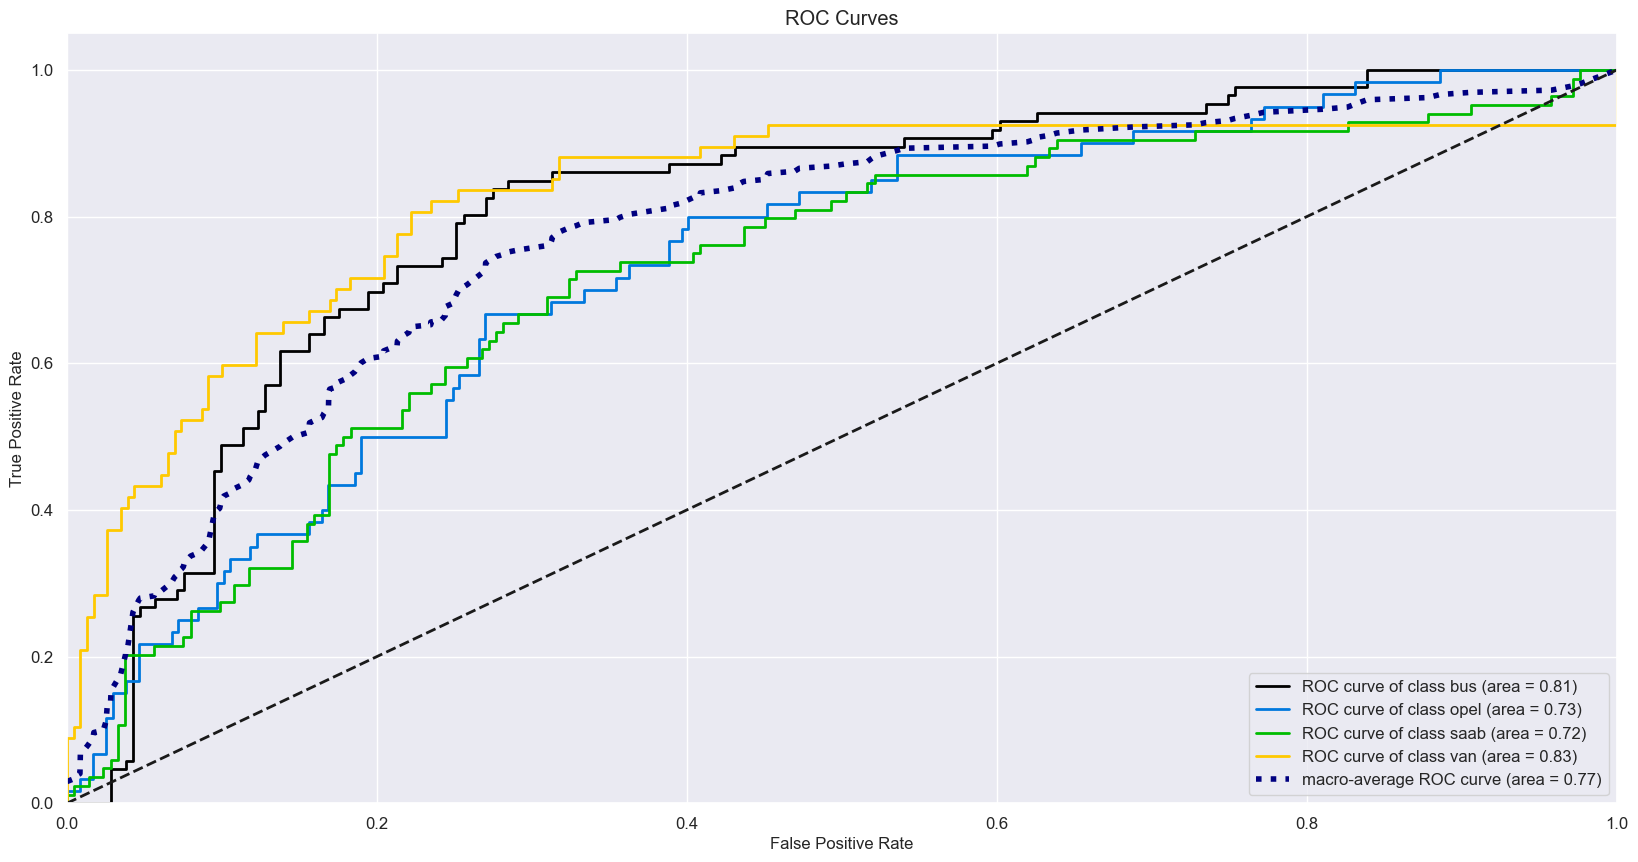

In [98]:
plot_roc(y_test, y_prob, figsize=(20, 10), plot_micro=False)

#### 2.5. Decision tree
* Now train a desicion tree on the same data. Find optimal tree depth (`max_depth`) using cross-validation.

* Measure the model quality using the same metrics you used above.

In [99]:
from sklearn.tree import DecisionTreeClassifier

In [100]:
max_depth = range(1, 70)
hyperparameters = dict(max_depth=max_depth)

# cleaner = CustomTransformer()
# X_train_df = cleaner.fit_transform(X_train_new)

clf = DecisionTreeClassifier(random_state=42)

randomizedsearch = RandomizedSearchCV(
    clf,
    hyperparameters, 
    cv=5, 
    random_state=42
)
best_model_dt = randomizedsearch.fit(X_train_new, y_train_tr)
print(best_model_dt.best_estimator_)

DecisionTreeClassifier(max_depth=13, random_state=42)


In [101]:
X_train_new.shape, y_train_tr.shape

((537, 18), (537,))

In [102]:
pipe_dt = Pipeline(
    steps=[
#         ("cleaner", CustomTransformer()),
        ("clf", best_model_dt.best_estimator_)   ]
)

pipe_dt.fit(X_train_new, y_train_tr)
y_pred = pipe_dt.predict(X_test)
y_prob = pipe_dt.predict_proba(X_test)

print(
    f"f1 score = {round(f1_score(y_test_tr, y_pred, average='micro'), 4)}",
    f"accuracy score = {round(accuracy_score(y_test_tr, y_pred), 4)}",
    sep="\n"
)

f1 score = 0.7239
accuracy score = 0.7239


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

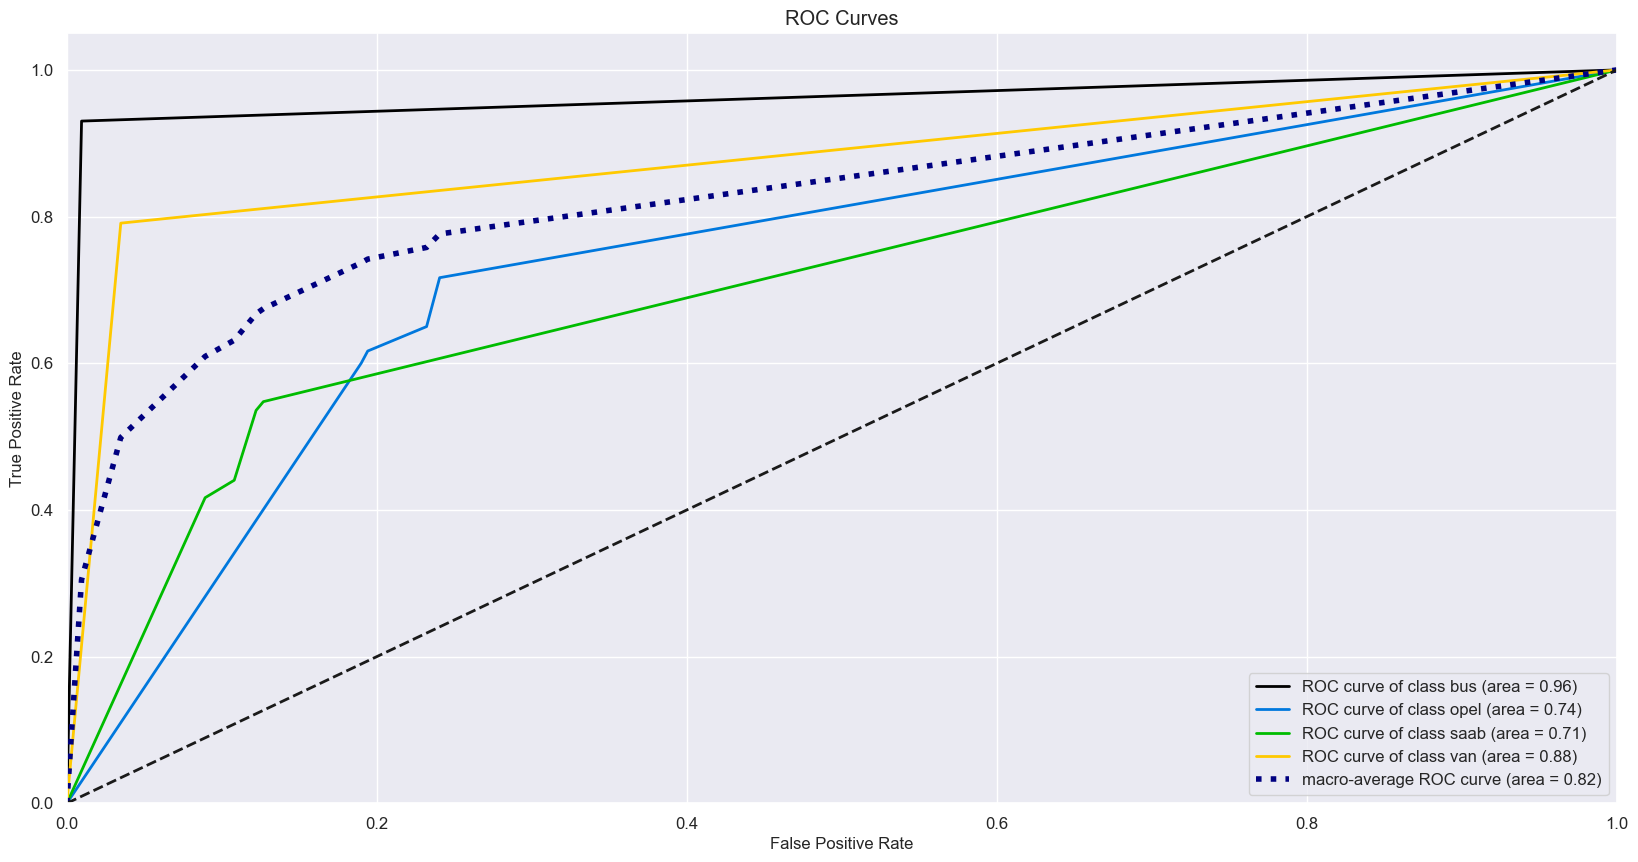

In [103]:
plot_roc(y_test, y_prob, figsize=(20, 10), plot_micro=False)

#### 2.6. Bagging.
Here starts the ensembling part.

First we will use the __Bagging__ approach. Build an ensemble of $N$ algorithms varying N from $N_{min}=2$ to $N_{max}=100$ (with step 5).

We will build two ensembles: of logistic regressions and of decision trees.

*Comment: each ensemble should be constructed from models of the same family, so logistic regressions should not be mixed up with decision trees.*


*Hint 1: To build a __Bagging__ ensebmle varying the ensemble size efficiently you might generate $N_{max}$ subsets of `train` data (of the same size as the original dataset) using bootstrap procedure once. Then you train a new instance of logistic regression/decision tree with optimal hyperparameters you estimated before on each subset (so you train it from scratch). Finally, to get an ensemble of $N$ models you average the $N$ out of $N_{max}$ models predictions.*

*Hint 2: sklearn might help you with this taks. Some appropriate function/class might be out there.*

* Plot `f1` and `accuracy` scores plots w.r.t. the size of the ensemble.

* Briefly analyse the plot. What is the optimal number of algorithms? Explain your answer.

* How do you think, are the hyperparameters for the decision trees you found in 2.5 optimal for trees used in ensemble? 

In [104]:
from sklearn.ensemble import BaggingClassifier

In [105]:
def calculate_score(estimator, algos):
    f1_scores, accuracy_scores  = [], []
    for n_algorithms in algos:
        bagging_clf = BaggingClassifier(
            estimator=estimator, 
            n_estimators=n_algorithms, 
            random_state=42
        )
        bagging_clf.fit(X_train_new, y_train_tr)
        y_pred = bagging_clf.predict(X_test)
        f1_scores.append(round(f1_score(y_test_tr, y_pred, average='weighted'), 5))
        accuracy_scores.append(round(accuracy_score(y_test_tr, y_pred), 5))
    return [f1_scores, accuracy_scores]

def scoresplot(xSize, ySize, scores, ticks, colors, base_clf_name):
    _, axes = plt.subplots(2, 1, figsize=(xSize, ySize))
    
    names = ["f1 score", "accuracy score"]
        
    for i,  (ax, sc) in enumerate(zip(axes, scores)):
        sns.lineplot(x=ticks, y=sc, ax=ax, color=colors[i])
        ax.xaxis.set_ticks(ticks)
        ax.set_xlabel('Number of algorithms')
        ax.set_ylabel('Score')
        ax.set_title(f"{names[i]} for bagging with {base_clf_name} as estimator")

In [106]:
N_min, N_max = 2, 100 + 1
N_step = 5
algorithms = range(N_min, N_max, N_step)

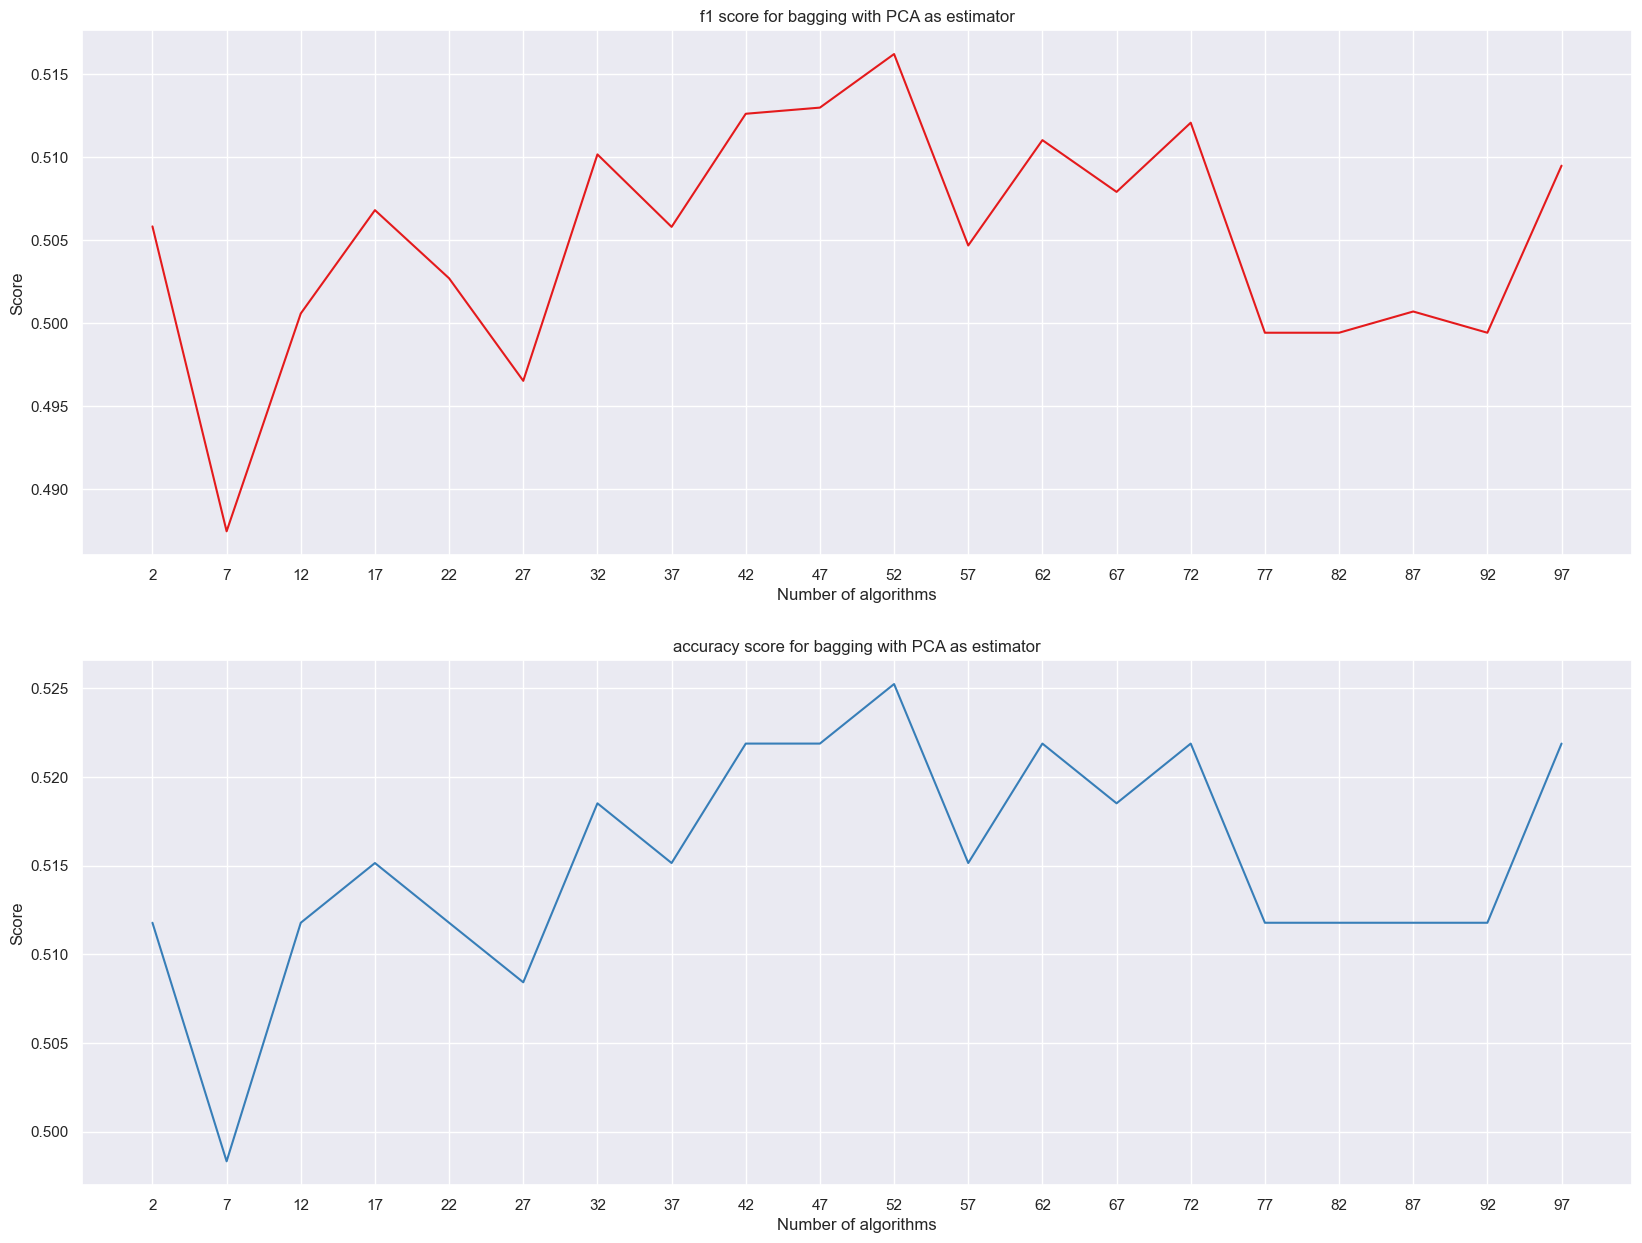

In [107]:
scores_pca = calculate_score(estimator=pipe_pca, algos=algorithms)
scoresplot(20, 15, scores_pca, algorithms, colors=pal.as_hex()[:2], base_clf_name="PCA")

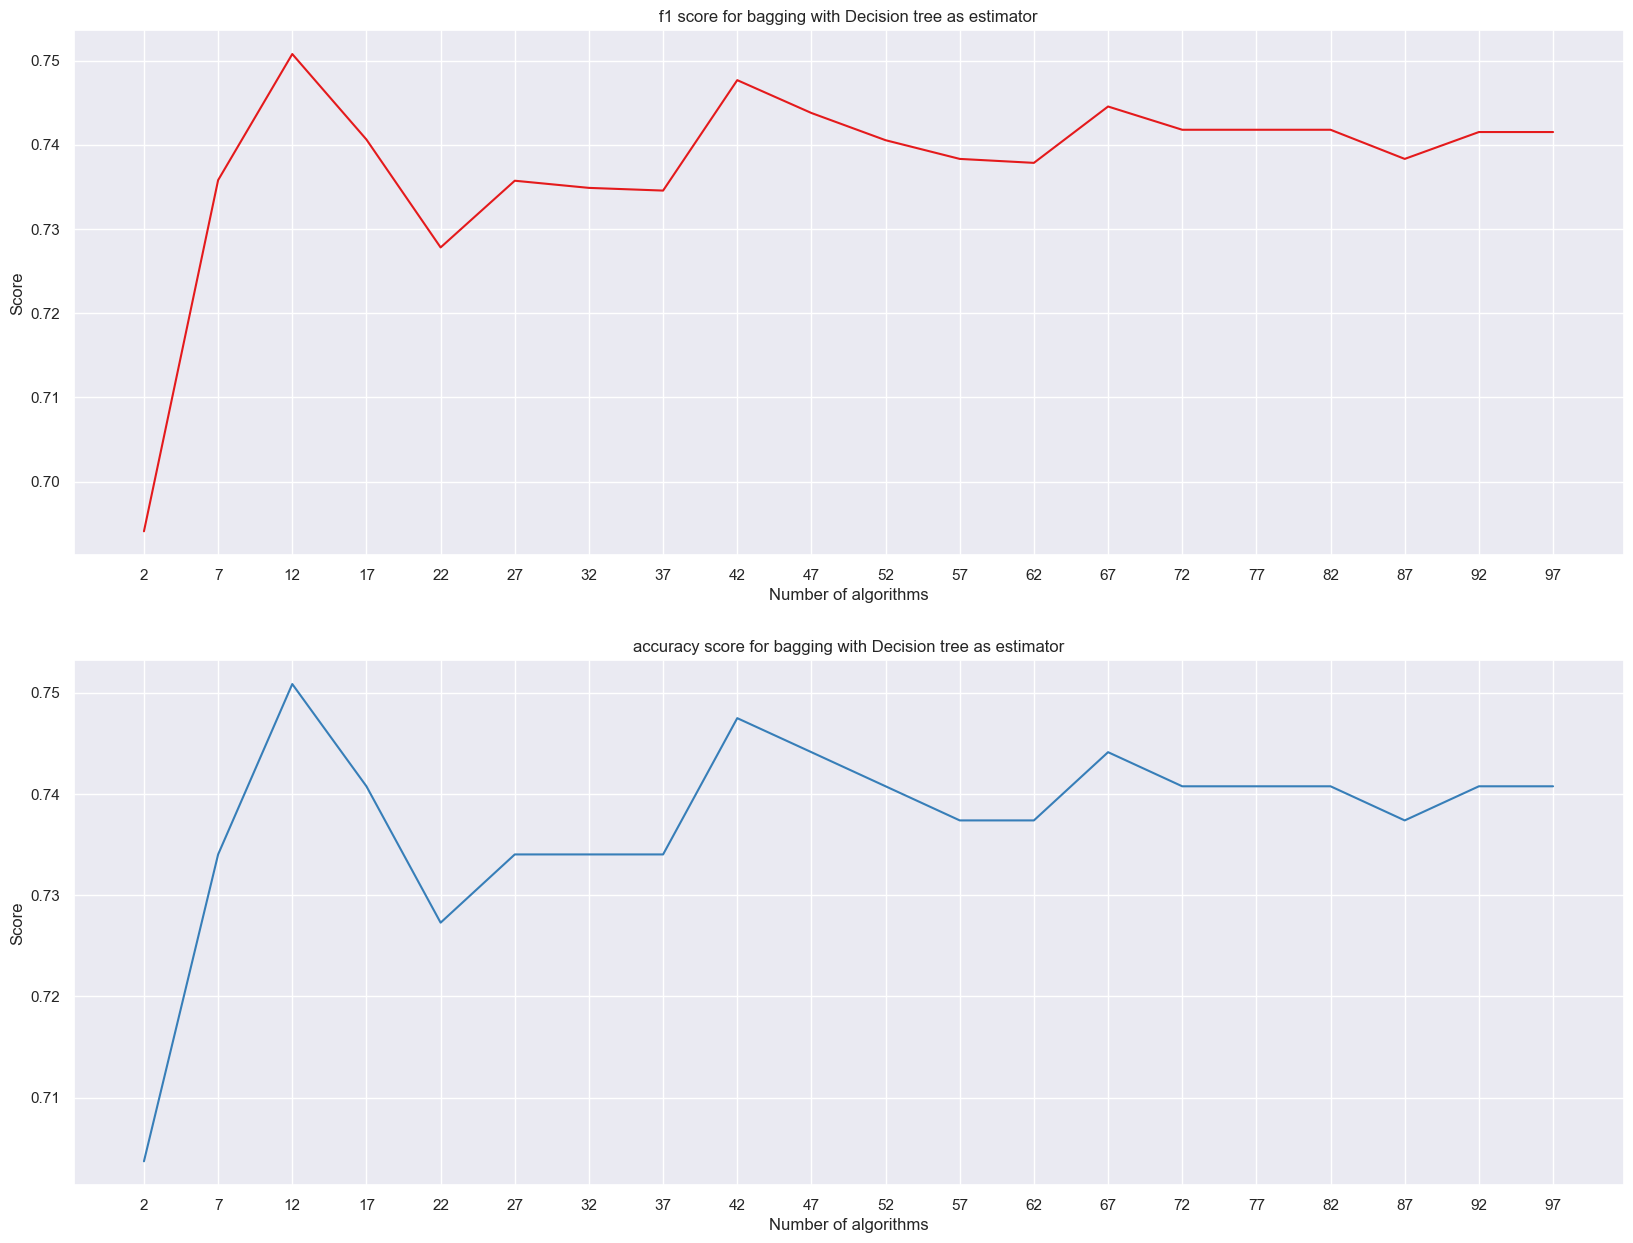

In [108]:
scores_dt = calculate_score(estimator=pipe_dt, algos=algorithms)
scoresplot(20, 15, scores_dt, algorithms, colors=pal.as_hex()[:2], base_clf_name="Decision tree")

#### 2.7. Random Forest
Now we will work with the Random Forest (its `sklearn` implementation).

* * Plot `f1` and `accuracy` scores plots w.r.t. the number of trees in Random Forest.

* What is the optimal number of trees you've got? Is it different from the optimal number of logistic regressions/decision trees in 2.6? Explain the results briefly.

In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
N_min, N_max = 100, 600 + 1
N_step = 50
estimators = range(N_min, N_max, N_step)

In [111]:
f1_scores, accuracy_scores  = [], []
for n_est in estimators:
    clf = RandomForestClassifier(
        n_estimators = n_est, 
        random_state=42
    )
    pipe_rf = Pipeline(
    steps=[
        ("cleaner", CustomTransformer()),
        ("clf",clf ) ]
    )
    pipe_rf.fit(X_train_new, y_train_tr)
    y_pred = pipe_rf.predict(X_test)
    f1_scores.append(round(f1_score(y_test_tr, y_pred, average='weighted'), 5))
    accuracy_scores.append(round(accuracy_score(y_test_tr, y_pred), 5))
scores_rf = [f1_scores, accuracy_scores]

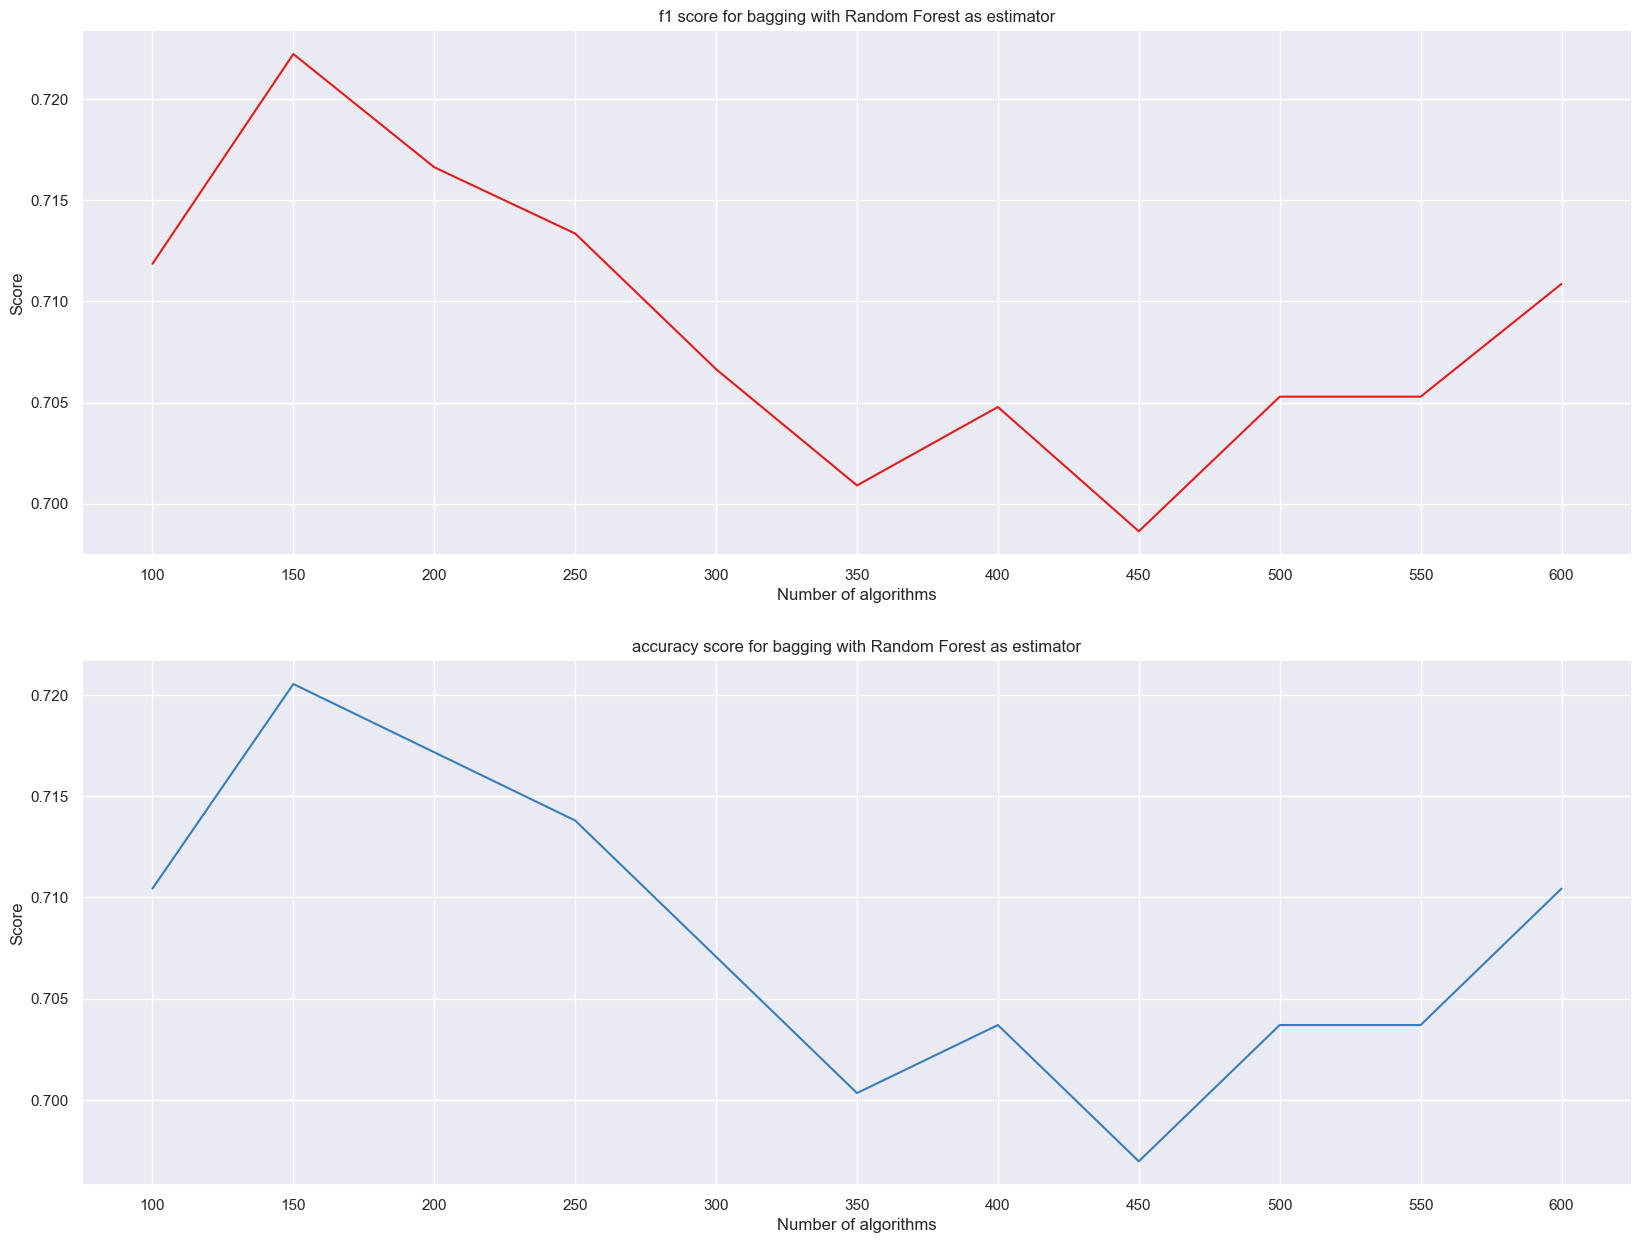

In [112]:
scoresplot(20, 15, scores_rf, estimators, colors=pal.as_hex()[:2], base_clf_name="Random Forest")

In [113]:
pipe_rf.set_params(clf__n_estimators=150)

Pipeline(steps=[('cleaner', CustomTransformer()),
                ('clf',
                 RandomForestClassifier(n_estimators=150, random_state=42))])

In [114]:
pipe_dt

Pipeline(steps=[('clf', DecisionTreeClassifier(max_depth=13, random_state=42))])

In [115]:
pipe_pca

Pipeline(steps=[('cleaner', CustomTransformer()), ('pca', PCA(n_components=6)),
                ('clf',
                 LogisticRegression(C=78.47599703514611, max_iter=500,
                                    multi_class='multinomial', solver='saga',
                                    tol=0.001))])

#### 2.8. Learning curve
Your goal is to estimate, how does the model behaviour change with the increase of the `train` dataset size.

* Split the training data into 10 equal (almost) parts. Then train the models from above (Logistic regression, Desicion Tree, Random Forest) with optimal hyperparameters you have selected on 1 part, 2 parts (combined, so the train size in increased by 2 times), 3 parts and so on.

* Build a plot of `accuracy` and `f1` scores on `test` part, varying the `train` dataset size (so the axes will be score - dataset size.

* Analyse the final plot. Can you make any conlusions using it? 

In [116]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

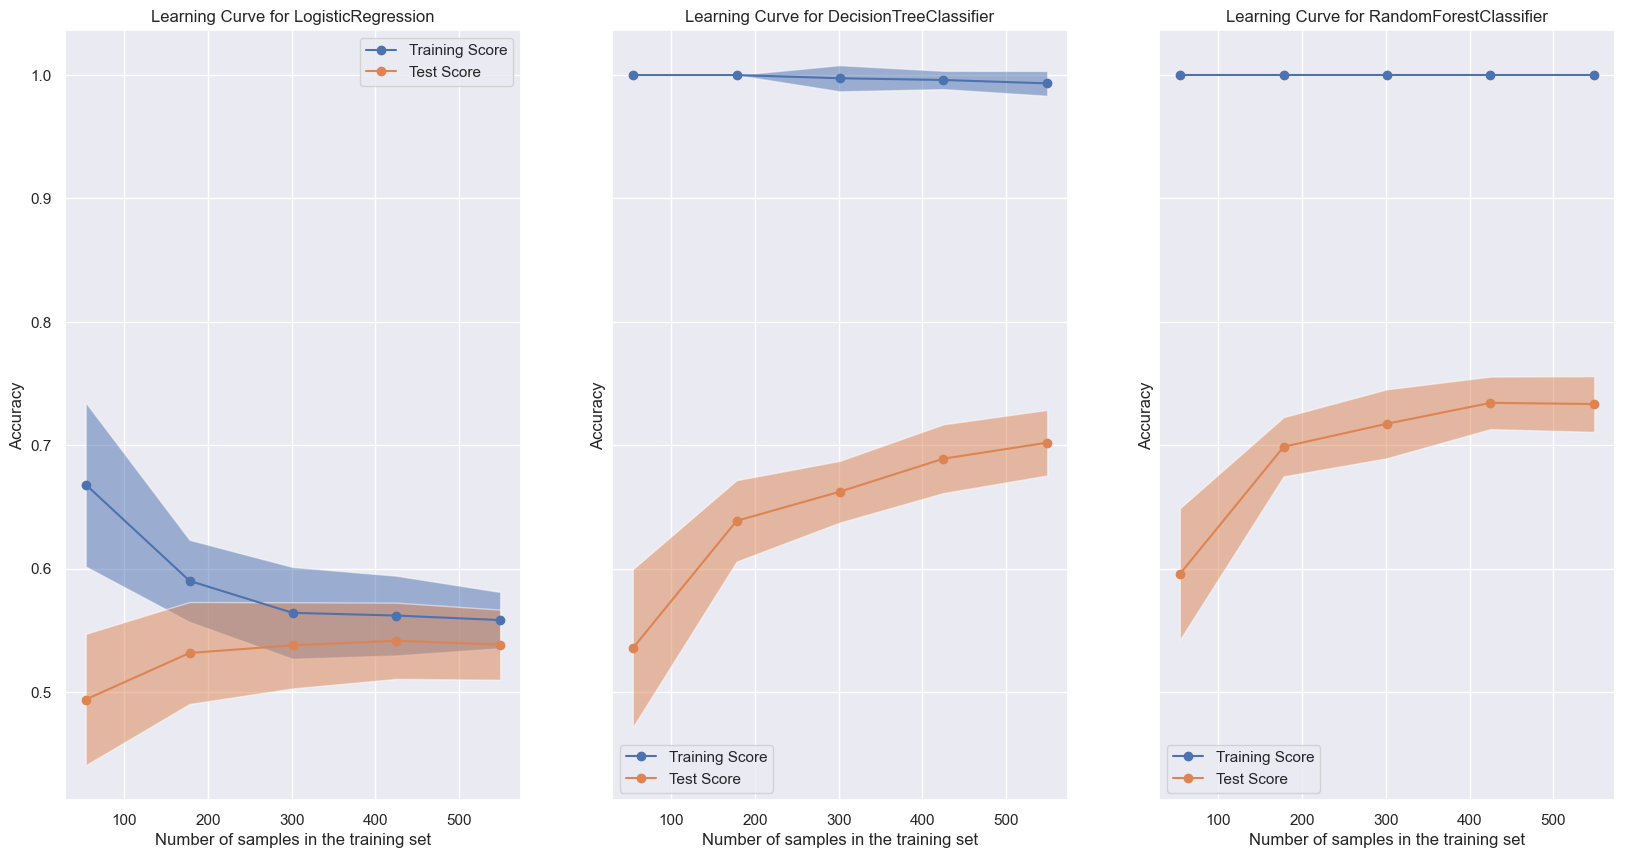

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)

common_params = {
    "X": data,
    "y": target,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.35, random_state=42),
    "score_type": "both",
    "n_jobs": 20,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy", #‘f1_weighted’
}

for ax_idx, estimator in enumerate([pipe_pca, pipe_dt, pipe_rf]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    if ax_idx == 0:
        ax[ax_idx].set_title(f"Learning Curve for {estimator.get_params().get('steps')[2][1].__class__.__name__}")
    elif ax_idx == 1:
        ax[ax_idx].set_title(f"Learning Curve for {estimator.get_params().get('steps')[0][1].__class__.__name__}")
    else:
        ax[ax_idx].set_title(f"Learning Curve for {estimator.get_params().get('steps')[1][1].__class__.__name__}")

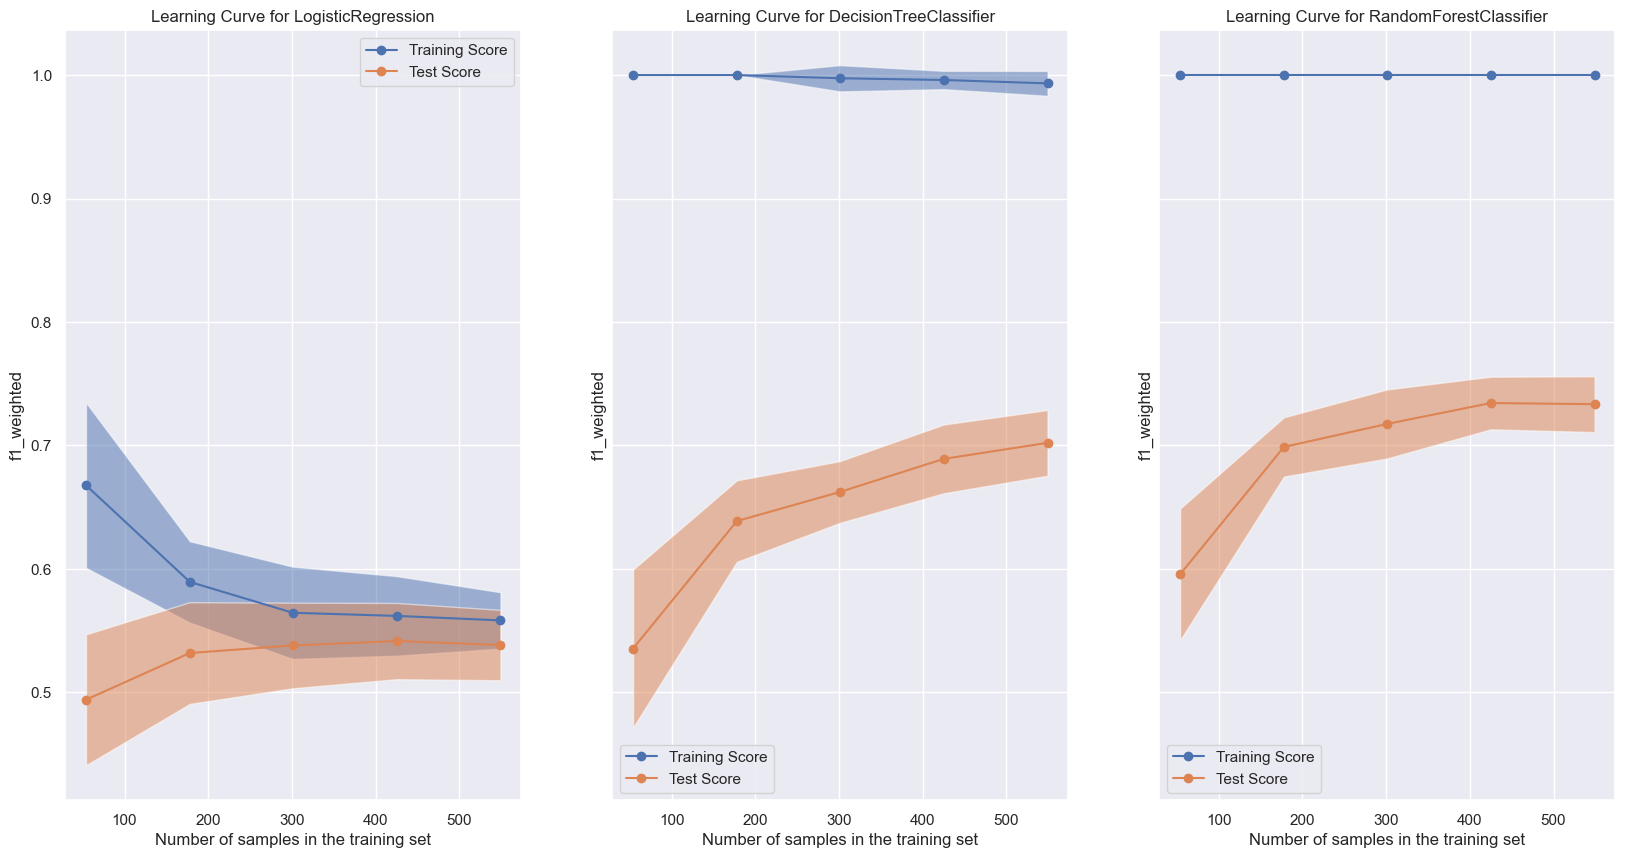

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)

common_params = {
    "X": data,
    "y": target,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.35, random_state=42),
    "score_type": "both",
    "n_jobs": 20,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f1_weighted"
}

for ax_idx, estimator in enumerate([pipe_pca, pipe_dt, pipe_rf]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    if ax_idx == 0:
        ax[ax_idx].set_title(f"Learning Curve for {estimator.get_params().get('steps')[2][1].__class__.__name__}")
    elif ax_idx == 1:
        ax[ax_idx].set_title(f"Learning Curve for {estimator.get_params().get('steps')[0][1].__class__.__name__}")
    else:
        ax[ax_idx].set_title(f"Learning Curve for {estimator.get_params().get('steps')[1][1].__class__.__name__}")